<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/Copy_of_AllEkphrasisvec4negpos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('all')
device_name = tf.test.gpu_device_name()
print(device_name)
df_train = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/train_clean.csv',names=['Tweet','Emotion'])
df_test = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Newdata/test_clean.csv',names=['Tweet','Emotion'])
df_train = df_train.sample(frac=1)
df_test = df_train.sample(frac=1)

Mounted at /content/drive
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...

In [ ]:
df_train.head(1000)

,Tweet,Emotion
2208,nicolepenney that suck I am go to be do summer...,2
9155,transit time is over tonight i work night shif...,0
11920,anoth friday night in man be skint is rubbish,2
7182,saschaillyvich i guess that mean you did not b...,2
1817,amyype lol i know i onli get to read it someti...,1
...,...,...
6236,realli want to go to the net,1
3581,tri to draw some mangaanim for our new websit ...,2
8196,just watch the quotfin breakquot final prison ...,1
6299,nobili i feel your pain mine is the same way,2


In [ ]:
df_test.Emotion.unique()

array(['0', '2', '1', '3', 'emotion'], dtype=object)

In [ ]:
df_train.nunique()

Tweet      12370
Emotion        5
dtype: int64

In [ ]:
category_dict = {'0':[1,0,0,0],'1':[0,1,0,0],'2':[0,0,1,0],'3':[0,0,0,1],'emotion':[1,0,0,0]}
train_data_tweet = [x.lower().split() for x in df_train['Tweet']]
train_data_cat = np.array([category_dict[x] for x in df_train['Emotion']])
test_data_tweet = [x.lower().split() for x in df_test['Tweet']]
test_data_cat = np.array([category_dict[x] for x in df_test['Emotion']])

data_tweet = train_data_tweet + test_data_tweet

In [ ]:
# Parameters
Min_count = 0
Embedding_size = 100
Window_size = 5
Negative_sampling = 00

In [ ]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)


In [ ]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.100d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [ ]:
def save_dict_to_file(dic):
    f = open("/content/drive/My Drive/InfluenceAnalysis/vocab1.txt",'w')
    for i in dic:
      f.write(str(i)+"\t")
      f.write(str(w2v_sg.wv.get_vector(i)))
      f.write("\n")
    f.close()
save_dict_to_file(vocab_sg)

In [ ]:
batch_size = 500
Max_input_size = max([len(x) for x in data_tweet])
mul_factor=1.5

In [ ]:
positive = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/positive-words.csv')
positive = list(positive['0'][1:])
negative = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/CodeMix/negative-words.csv')
negative = list(negative['0'][2:])
pn_dict = {}
for i in range(len(positive)):
  pn_dict[positive[i]] = 1

for i in range(len(negative)):
  pn_dict[negative[i]] = -1

In [ ]:
X_train = train_data_tweet
X_test = test_data_tweet
y_train = train_data_cat
y_test = test_data_cat 
X_train = [nltk.pos_tag(x) for x in X_train]
X_test = [nltk.pos_tag(x) for x in X_test]
X_train = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_train]
X_test = [[(i[0],i[1],pn_dict.get(i[0],1)) for i in x] for x in X_test]
result_table = [0,0,0,0,0,0,0,0,0]

In [ ]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(w2v.wv.word_vec(i[0]),i[1],i[2]) for i in x if i[0] in vocab]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='NN':
                tweet[z]=((tweet[z][0]+tweet[i][0])*mul_factor,tweet[z][1])
          if tweet[i][1][:2]=='RB':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='VB':
                tweet[z]=((tweet[z][0]+tweet[i][0])*mul_factor,tweet[z][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)          
      
def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size,mul_factor):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      res=[]
      for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]:
        tweet = [(vocab[i[0]],i[1],i[2]) for i in x if i[0] in vocab.keys()]
        l=len(tweet)
        for i in range(l):
          tweet[i]=((tweet[i][0]*tweet[i][2]),tweet[i][1],tweet[i][2])
        for i in range(l):
          if tweet[i][1][:2]=='JJ':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='NN':
                tweet[z]=((tweet[z][0]+tweet[i][0])*mul_factor,tweet[z][1])
          if tweet[i][1][:2]=='RB':
            for z in range(max(i-2,0),min(i+3,l)):
              if tweet[z][1][:2]=='VB':
                tweet[z]=((tweet[z][0]+tweet[i][0])*mul_factor,tweet[z][1])
        res+=[np.array([x[0] for x in tweet])]
      temp = np.array([np.pad(z.flatten(),(0,Max_input_size*Embedding_size-len(z.flatten()))).reshape(Max_input_size,Embedding_size) for z in res])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

In [ ]:
epochs = 50

In [ ]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(50))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


Epoch 1/50
24/24 [==============================] - 5s 223ms/step - loss: 1.2096 - accuracy: 0.5680
Epoch 2/50
24/24 [==============================] - 5s 217ms/step - loss: 0.9864 - accuracy: 0.5857
Epoch 3/50
24/24 [==============================] - 5s 222ms/step - loss: 0.9834 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 5s 223ms/step - loss: 0.9824 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 5s 220ms/step - loss: 0.9798 - accuracy: 0.5857
Epoch 6/50
24/24 [==============================] - 5s 223ms/step - loss: 0.9759 - accuracy: 0.5858
Epoch 7/50
24/24 [==============================] - 6s 232ms/step - loss: 0.9716 - accuracy: 0.5857
Epoch 8/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9690 - accuracy: 0.5857
Epoch 9/50
24/24 [==============================] - 5s 226ms/step - loss: 0.9653 - accuracy: 0.5857
Epoch 10/50
24/24 [==============================] - 5s 221ms/step - loss: 0.9637 - accuracy: 0.5857

In [ ]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_bi = model_sg_bi.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

Epoch 1/50
24/24 [==============================] - 5s 218ms/step - loss: 1.2231 - accuracy: 0.5327
Epoch 2/50
24/24 [==============================] - 5s 224ms/step - loss: 0.9891 - accuracy: 0.5857
Epoch 3/50
24/24 [==============================] - 5s 223ms/step - loss: 0.9759 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 6s 229ms/step - loss: 0.9691 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 6s 229ms/step - loss: 0.9632 - accuracy: 0.5857
Epoch 6/50
24/24 [==============================] - 6s 230ms/step - loss: 0.9580 - accuracy: 0.5856
Epoch 7/50
24/24 [==============================] - 5s 228ms/step - loss: 0.9538 - accuracy: 0.5862
Epoch 8/50
24/24 [==============================] - 5s 225ms/step - loss: 0.9507 - accuracy: 0.5861
Epoch 9/50
24/24 [==============================] - 5s 220ms/step - loss: 0.9483 - accuracy: 0.5857
Epoch 10/50
24/24 [==============================] - 5s 224ms/step - loss: 0.9464 - accuracy: 0.5847

In [ ]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(50))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_rnn = model_sg_rnn.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[2]=history[1]
print("SG_RNN")

Epoch 1/50
24/24 [==============================] - 6s 230ms/step - loss: 1.1015 - accuracy: 0.5351
Epoch 2/50
24/24 [==============================] - 6s 232ms/step - loss: 0.9908 - accuracy: 0.5856
Epoch 3/50
24/24 [==============================] - 6s 235ms/step - loss: 0.9871 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9862 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 6s 230ms/step - loss: 0.9858 - accuracy: 0.5857
Epoch 6/50
24/24 [==============================] - 6s 230ms/step - loss: 0.9857 - accuracy: 0.5857
Epoch 7/50
24/24 [==============================] - 6s 233ms/step - loss: 0.9857 - accuracy: 0.5857
Epoch 8/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9856 - accuracy: 0.5857
Epoch 9/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9857 - accuracy: 0.5857
Epoch 10/50
24/24 [==============================] - 5s 229ms/step - loss: 0.9857 - accuracy: 0.5857

In [ ]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(50))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_lstm = model_cbow.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

Epoch 1/50
24/24 [==============================] - 6s 230ms/step - loss: 1.2431 - accuracy: 0.5688
Epoch 2/50
24/24 [==============================] - 5s 227ms/step - loss: 1.0075 - accuracy: 0.5857
Epoch 3/50
24/24 [==============================] - 6s 233ms/step - loss: 0.9842 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9803 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 5s 221ms/step - loss: 0.9760 - accuracy: 0.5857
Epoch 6/50
24/24 [==============================] - 5s 223ms/step - loss: 0.9727 - accuracy: 0.5857
Epoch 7/50
24/24 [==============================] - 5s 223ms/step - loss: 0.9675 - accuracy: 0.5857
Epoch 8/50
24/24 [==============================] - 5s 222ms/step - loss: 0.9647 - accuracy: 0.5861
Epoch 9/50
24/24 [==============================] - 5s 224ms/step - loss: 0.9621 - accuracy: 0.5857
Epoch 10/50
24/24 [==============================] - 6s 234ms/step - loss: 0.9593 - accuracy: 0.5853

In [ ]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_bi = model_cbow_bi.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

Epoch 1/50
24/24 [==============================] - 6s 232ms/step - loss: 1.2255 - accuracy: 0.5424
Epoch 2/50
24/24 [==============================] - 6s 233ms/step - loss: 0.9982 - accuracy: 0.5857
Epoch 3/50
24/24 [==============================] - 5s 229ms/step - loss: 0.9761 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9706 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9626 - accuracy: 0.5860
Epoch 6/50
24/24 [==============================] - 6s 230ms/step - loss: 0.9560 - accuracy: 0.5852
Epoch 7/50
24/24 [==============================] - 6s 231ms/step - loss: 0.9516 - accuracy: 0.5853
Epoch 8/50
24/24 [==============================] - 6s 232ms/step - loss: 0.9477 - accuracy: 0.5857
Epoch 9/50
24/24 [==============================] - 6s 239ms/step - loss: 0.9433 - accuracy: 0.5863
Epoch 10/50
24/24 [==============================] - 6s 233ms/step - loss: 0.9394 - accuracy: 0.5870

In [ ]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(50))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_cbow_rnn = model_cbow_rnn.fit_generator(generator = vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/50
24/24 [==============================] - 6s 248ms/step - loss: 1.1320 - accuracy: 0.5229
Epoch 2/50
24/24 [==============================] - 6s 236ms/step - loss: 0.9923 - accuracy: 0.5852
Epoch 3/50
24/24 [==============================] - 6s 240ms/step - loss: 0.9869 - accuracy: 0.5856
Epoch 4/50
24/24 [==============================] - 6s 239ms/step - loss: 0.9861 - accuracy: 0.5856
Epoch 5/50
24/24 [==============================] - 6s 242ms/step - loss: 0.9858 - accuracy: 0.5856
Epoch 6/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9854 - accuracy: 0.5856
Epoch 7/50
24/24 [==============================] - 6s 236ms/step - loss: 0.9856 - accuracy: 0.5856
Epoch 8/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9851 - accuracy: 0.5857
Epoch 9/50
24/24 [==============================] - 6s 238ms/step - loss: 0.9847 - accuracy: 0.5858
Epoch 10/50
24/24 [==============================] - 6s 239ms/step - loss: 0.9849 - accuracy: 0.5857

In [ ]:
epochs=50
Embedding_size=100

In [ ]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove.add(tf.keras.layers.LSTM(50))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_lstm = model_glove.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


Epoch 1/50
24/24 [==============================] - 1s 46ms/step - loss: 1.1943 - accuracy: 0.5655
Epoch 2/50
24/24 [==============================] - 1s 47ms/step - loss: 0.9865 - accuracy: 0.5858
Epoch 3/50
24/24 [==============================] - 1s 45ms/step - loss: 0.9793 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9737 - accuracy: 0.5858
Epoch 5/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9708 - accuracy: 0.5858
Epoch 6/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9671 - accuracy: 0.5858
Epoch 7/50
24/24 [==============================] - 1s 47ms/step - loss: 0.9597 - accuracy: 0.5859
Epoch 8/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9504 - accuracy: 0.5860
Epoch 9/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9435 - accuracy: 0.5876
Epoch 10/50
24/24 [==============================] - 1s 46ms/step - loss: 0.9363 - accuracy: 0.5914
Epoch 11/

In [ ]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_bi = model_glove_bi.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

Epoch 1/50
24/24 [==============================] - 1s 48ms/step - loss: 1.0689 - accuracy: 0.5795
Epoch 2/50
24/24 [==============================] - 1s 47ms/step - loss: 0.9598 - accuracy: 0.5859
Epoch 3/50
24/24 [==============================] - 1s 47ms/step - loss: 0.9397 - accuracy: 0.5873
Epoch 4/50
24/24 [==============================] - 1s 49ms/step - loss: 0.9243 - accuracy: 0.5897
Epoch 5/50
24/24 [==============================] - 1s 48ms/step - loss: 0.9102 - accuracy: 0.5952
Epoch 6/50
24/24 [==============================] - 1s 50ms/step - loss: 0.8975 - accuracy: 0.6053
Epoch 7/50
24/24 [==============================] - 1s 48ms/step - loss: 0.8857 - accuracy: 0.6080
Epoch 8/50
24/24 [==============================] - 1s 47ms/step - loss: 0.8743 - accuracy: 0.6155
Epoch 9/50
24/24 [==============================] - 1s 49ms/step - loss: 0.8629 - accuracy: 0.6207
Epoch 10/50
24/24 [==============================] - 1s 49ms/step - loss: 0.8521 - accuracy: 0.6287
Epoch 11/

In [ ]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,100)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(50))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_glove_rnn = model_glove_rnn.fit_generator(generator = glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/50
24/24 [==============================] - 2s 64ms/step - loss: 1.1201 - accuracy: 0.5362
Epoch 2/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9909 - accuracy: 0.5853
Epoch 3/50
24/24 [==============================] - 2s 63ms/step - loss: 0.9862 - accuracy: 0.5857
Epoch 4/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9851 - accuracy: 0.5857
Epoch 5/50
24/24 [==============================] - 2s 63ms/step - loss: 0.9844 - accuracy: 0.5857
Epoch 6/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9811 - accuracy: 0.5859
Epoch 7/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9765 - accuracy: 0.5856
Epoch 8/50
24/24 [==============================] - 1s 61ms/step - loss: 0.9735 - accuracy: 0.5867
Epoch 9/50
24/24 [==============================] - 1s 60ms/step - loss: 0.9693 - accuracy: 0.5890
Epoch 10/50
24/24 [==============================] - 1s 62ms/step - loss: 0.9656 - accuracy: 0.5914
Epoch 11/

In [ ]:
model_sg1 = tf.keras.Sequential()
model_sg1.add(tf.keras.Input(shape=(Max_input_size,100)))
model_sg1.add(tf.keras.layers.LSTM(64))
model_sg1.add(tf.keras.layers.Dropout(0.2))
model_sg1.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg1.add(tf.keras.layers.Dropout(0.2))
model_sg1.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg1.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
history_sg_lstm = model_sg1.fit_generator(generator = vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size,mul_factor),steps_per_epoch=int(len(X_train)/batch_size),epochs=epochs)
history = model_sg1.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size,mul_factor),steps=int(len(y_test)/batch_size))
print(history)

result_table+=[history[1]]
print("SG_LSTM")

Epoch 1/40
24/24 [==============================] - 6s 244ms/step - loss: 1.2387 - accuracy: 0.5730
Epoch 2/40
24/24 [==============================] - 6s 245ms/step - loss: 1.0254 - accuracy: 0.5867
Epoch 3/40
24/24 [==============================] - 6s 247ms/step - loss: 1.0017 - accuracy: 0.5857
Epoch 4/40
24/24 [==============================] - 6s 244ms/step - loss: 0.9954 - accuracy: 0.5869
Epoch 5/40
24/24 [==============================] - 6s 246ms/step - loss: 0.9904 - accuracy: 0.5865
Epoch 6/40
24/24 [==============================] - 6s 246ms/step - loss: 0.9857 - accuracy: 0.5867
Epoch 7/40
24/24 [==============================] - 6s 253ms/step - loss: 0.9800 - accuracy: 0.5868
Epoch 8/40
24/24 [==============================] - 6s 247ms/step - loss: 0.9761 - accuracy: 0.5871
Epoch 9/40
24/24 [==============================] - 6s 244ms/step - loss: 0.9745 - accuracy: 0.5870
Epoch 10/40
24/24 [==============================] - 6s 247ms/step - loss: 0.9703 - accuracy: 0.5869

In [ ]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])

	Lstm			BiLstm			Rnn
sg [0.7118333578109741, 0.7118333578109741, 0.6471666693687439]
cbow [0.7007499933242798, 0.7209166884422302, 0.5951666831970215]
glove [0.7717499732971191, 0.859333336353302, 0.6794999837875366]


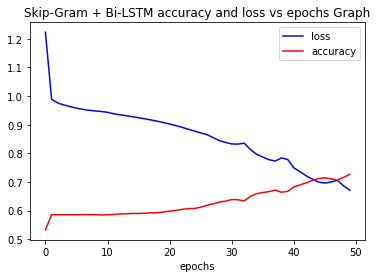

In [ ]:
plt.title("Skip-Gram + Bi-LSTM accuracy and loss vs epochs Graph")
plt.plot(history_sg_bi.history['loss'],c='b',label='loss')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()

In [ ]:
print(result_table[9])

IndexError: ignored